In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump

# Kontext

https://ourworldindata.org/

In [22]:
# Load the data files
file_path_female = 'data/remaining-life-expectancy-at-different-ages-females.csv'
file_path_male = 'data/remaining-life-expectancy-at-different-ages-males.csv'

female_data = pd.read_csv(file_path_female)
male_data = pd.read_csv(file_path_male)

#### Create basic df structure with clear target variable of remaining-life-expectancy-at-different-ages-females and males

In [23]:
# Extracting age columns and reshaping the female data
female_reshaped = female_data.melt(id_vars=['Entity', 'Year', 'Code'],
                                   var_name='Age', value_name='Remaining Life Expectancy')
female_reshaped['Sex'] = 'Female'

# Extracting age columns and reshaping the male data, including 'Code'
male_reshaped = male_data.melt(id_vars=['Entity', 'Year', 'Code'],
                               var_name='Age', value_name='Remaining Life Expectancy')
male_reshaped['Sex'] = 'Male'

# Concatenate the reshaped dataframes with 'Code'
combined_data = pd.concat([female_reshaped, male_reshaped])

# Extract the age from the 'Age' column
combined_data['Age'] = combined_data['Age'].str.extract(r'Age: (\d+)').astype(int)

# Reordering columns for clarity
combined_data = combined_data[['Entity', 'Code', 'Year', 'Sex', 'Age', 'Remaining Life Expectancy']]

combined_data.head()

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
0,Afghanistan,AFG,1950,Female,0,28.3905
1,Afghanistan,AFG,1951,Female,0,28.6345
2,Afghanistan,AFG,1952,Female,0,29.1260
3,Afghanistan,AFG,1953,Female,0,29.6212
4,Afghanistan,AFG,1954,Female,0,29.9004


# Explorative Datenanalyse (EDA)

In [24]:
combined_data.shape

(278908, 6)

In [25]:
combined_data.describe()

,Year,Age,Remaining Life Expectancy
count,278908.000000,278908.000000,278908.000000
mean,1978.822658,34.285714,38.468101
std,32.813750,27.701077,22.017019
min,1751.000000,0.000000,1.846400
25%,1963.000000,10.000000,15.169150
50%,1983.000000,25.000000,42.852350
75%,2002.000000,65.000000,56.466300
max,2021.000000,80.000000,88.727200


# Unifying & Transformation

Based on an analysis of the available datasets, we have decided to limit the data range to the years 2000 to 2020. This will help us manage the amount of missing data (NaN) more effectively.

In [26]:
# Filtering the data for years between 2000 and 2020, removing rows without a 'Code' variable, and excluding the 'World'
filtered_data = combined_data.dropna(subset=['Code'])
filtered_data = filtered_data[(filtered_data['Year'] >= 2000) & (filtered_data['Year'] <= 2020) & (filtered_data['Entity'] != 'World')]

filtered_data.to_csv('filtered_data-2000_2020.csv', index=False)
filtered_data.head()


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
50,Afghanistan,AFG,2000,Female,0,56.8579
51,Afghanistan,AFG,2001,Female,0,57.3437
52,Afghanistan,AFG,2002,Female,0,57.6715
53,Afghanistan,AFG,2003,Female,0,58.6498
54,Afghanistan,AFG,2004,Female,0,59.2159


#### Adding more data

In [27]:
# Load the additional data files
file_path_education_expenditure = 'data/total-government-expenditure-on-education-gdp.csv'
file_path_internet_usage = 'data/share-of-individuals-using-the-internet.csv'
file_path_electricity_access = 'data/share-of-the-population-with-access-to-electricity.csv'
file_path_sanitation = 'data/share-using-safely-managed-sanitation.csv'
file_path_smoking = 'data/share-of-adults-who-smoke.csv'
file_path_gdp = 'data/gdp.csv'
file_path_meat_supply = 'data/meat-supply-per-person.csv'
file_path_obesity = 'data/obesity.csv'
file_path_healthcare_spending = 'data/public-healthcare-spending-share-gdp.csv'
file_path_air_pollution = 'data/pm25-air-pollution.csv'
file_path_democracy_index = 'data/DemocracyIndex.csv'

# Reading the data files into DataFrames
education_expenditure_data = pd.read_csv(file_path_education_expenditure)
internet_usage_data = pd.read_csv(file_path_internet_usage)
electricity_access_data = pd.read_csv(file_path_electricity_access)
sanitation_data = pd.read_csv(file_path_sanitation)
smoking_data = pd.read_csv(file_path_smoking)
gdp_data = pd.read_csv(file_path_gdp)
meat_supply_data = pd.read_csv(file_path_meat_supply)
obesity_data = pd.read_csv(file_path_obesity)
healthcare_spending_data = pd.read_csv(file_path_healthcare_spending)
air_pollution_data = pd.read_csv(file_path_air_pollution)

# Reading and selecting specific columns from the Democracy Index file
democracy_index_data = pd.read_csv(file_path_democracy_index)[['Entity', 'Code', 'Year', 'Electoral democracy index']]

# Joining all these dataframes with the filtered_data dataframe based on 'Entity' and 'Year'
# Only join when the year exists in the filtered_data
# Adding custom suffixes to handle duplicate column names
merged_data = filtered_data
for df in [education_expenditure_data, internet_usage_data, electricity_access_data, 
           sanitation_data, smoking_data, gdp_data, meat_supply_data, 
           obesity_data, healthcare_spending_data, air_pollution_data, democracy_index_data]:
    merged_data = merged_data.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Dropping extra columns created due to overlapping column names (if any)
columns_to_drop = [col for col in merged_data.columns if '_extra' in col]
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data.sample(10)

merged_data.to_csv('merged_data.csv', index=False)



##### Checking if data is correctly merged

In [28]:
# Filter the DataFrame for Switzerland and the year 2010
switzerland_data_2010 = merged_data[(merged_data['Entity'] == 'Switzerland') & (merged_data['Year'] == 2010)]

switzerland_data_2010

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
4315,Switzerland,CHE,2010,Female,0,84.3602,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
9271,Switzerland,CHE,2010,Female,10,74.7753,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
14227,Switzerland,CHE,2010,Female,15,69.8006,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
19183,Switzerland,CHE,2010,Female,25,59.9133,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
24139,Switzerland,CHE,2010,Female,45,40.3310,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
29095,Switzerland,CHE,2010,Female,65,21.9793,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
34051,Switzerland,CHE,2010,Female,80,9.9016,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
39007,Switzerland,CHE,2010,Male,0,80.0230,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
43963,Switzerland,CHE,2010,Male,10,70.3838,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
48919,Switzerland,CHE,2010,Male,15,65.4156,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899


In [29]:
print("Basic Information:")
print(merged_data.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69384 entries, 0 to 69383
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Entity                                                       69384 non-null  object 
 1   Code                                                         69384 non-null  object 
 2   Year                                                         69384 non-null  int64  
 3   Sex                                                          69384 non-null  object 
 4   Age                                                          69384 non-null  int32  
 5   Remaining Life Expectancy                                    69384 non-null  float64
 6   Gov expenditure on education (%)                             42014 non-null  float64
 7   Internet usage (% of population)                         

In [30]:
print("\nDescriptive Statistics for Numerical Columns:")
print(merged_data.describe())


Descriptive Statistics for Numerical Columns:
               Year           Age  Remaining Life Expectancy  \
count  69384.000000  69384.000000               69384.000000   
mean    2010.000000     34.285714                  42.454423   
std        6.055344     27.701227                  23.715293   
min     2000.000000      0.000000                   3.186500   
25%     2005.000000     10.000000                  17.870450   
50%     2010.000000     25.000000                  48.133700   
75%     2015.000000     65.000000                  62.483350   
max     2020.000000     80.000000                  88.727200   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      42014.000000                      56980.000000   
mean                           4.462028                         33.996421   
std                            1.876947                         30.075464   
min                            0.127174                          0.0

In [31]:
print("\nMissing Values in Each Column:")
missing_values = merged_data.isnull().sum()
print(missing_values)


Missing Values in Each Column:
Entity                                                             0
Code                                                               0
Year                                                               0
Sex                                                                0
Age                                                                0
Remaining Life Expectancy                                          0
Gov expenditure on education (%)                               27370
Internet usage (% of population)                               12404
Access to electricity (% of population)                         7280
SanitationAccess                                               29232
SmokingRateAdults                                              53410
GDP ($)                                                        13328
Meat consumptionm in kg per year per capita                    17682
ObesityRate (BMI > 30)                                         23926
He

In [32]:
print("\nPercentage of Missing Values in Each Column:")
missing_values_percent = (merged_data.isnull().sum() / 69678) * 100
print(missing_values_percent)



Percentage of Missing Values in Each Column:
Entity                                                          0.000000
Code                                                            0.000000
Year                                                            0.000000
Sex                                                             0.000000
Age                                                             0.000000
Remaining Life Expectancy                                       0.000000
Gov expenditure on education (%)                               39.280691
Internet usage (% of population)                               17.801889
Access to electricity (% of population)                        10.448061
SanitationAccess                                               41.952984
SmokingRateAdults                                              76.652602
GDP ($)                                                        19.127989
Meat consumptionm in kg per year per capita                    25.376733
Obesi

In [33]:
# Filter for numeric columns before calculating the correlation matrix
numeric_data = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                                            Year  \
Year                                                1.000000e+00   
Age                                                -1.244713e-13   
Remaining Life Expectancy                           3.909766e-02   
Gov expenditure on education (%)                    4.727994e-03   
Internet usage (% of population)                    5.446421e-01   
Access to electricity (% of population)             1.169574e-01   
SanitationAccess                                    8.885377e-02   
SmokingRateAdults                                  -3.062335e-01   
GDP ($)                                             5.316461e-02   
Meat consumptionm in kg per year per capita         4.960406e-02   
ObesityRate (BMI > 30)                              1.900154e-01   
Healthcare spending (% of GDP)                      8.252165e-02   
air pollution, annual exposure (micrograms per ... -3.238032e-02   
Electoral democracy index  

# Data Cleansing

##### Gov expenditure on education (%) , Final DF: full_data_education_spendings_2000_2020

In [34]:
# Drop rows where 'Code' is NaN
education_expenditure_data = education_expenditure_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = education_expenditure_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = education_expenditure_data['Entity'].unique()
full_years_range = range(education_expenditure_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, education_expenditure_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)


# Filter the data to keep only the years from 2000 to 2020
full_data_education_spendings_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_education_spendings_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_education_spendings_2000_2020.update(group)


# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_education_spendings_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

United Arab Emirates: 19 NaNs filled with median
Cayman Islands: 18 NaNs filled with median
Suriname: 15 NaNs filled with median
Curacao: 12 NaNs filled with median
Turkmenistan: 12 NaNs filled with median
South Sudan: 11 NaNs filled with median
Uzbekistan: 11 NaNs filled with median
Palestine: 10 NaNs filled with median
East Timor: 8 NaNs filled with median
Liberia: 8 NaNs filled with median
Vietnam: 8 NaNs filled with median
Nauru: 7 NaNs filled with median
Serbia: 7 NaNs filled with median
American Samoa: 6 NaNs filled with median
Bahrain: 6 NaNs filled with median
Grenada: 3 NaNs filled with median
Liechtenstein: 3 NaNs filled with median
Bolivia: 2 NaNs filled with median
San Marino: 2 NaNs filled with median
Sao Tome and Principe: 2 NaNs filled with median
World: 1 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Gov expenditure on education (%)
26866,Tajikistan,2009.0,TJK,4.098310
9342,Estonia,2001.0,EST,5.228460
1192,Argentina,2005.0,ARG,3.860010
11606,Guinea-Bissau,2000.0,GNB,4.938411
22945,Saint Kitts and Nevis,2014.0,KNA,2.849904
6322,Comoros,2001.0,COM,2.244155
28386,Tuvalu,2019.0,TUV,3.730830
5569,Central African Republic,2003.0,CAF,1.539800
7247,Curacao,2020.0,CUW,7.725708
27326,Togo,2016.0,TGO,3.686490


In [35]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_education_spendings_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Gov expenditure on education (%)    0
dtype: int64


##### Internet usage (% of population), Final DF: full_data_internet_usage_2000_2020

In [36]:
# Drop rows where 'Code' is NaN
internet_usage_data = internet_usage_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = internet_usage_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = internet_usage_data['Entity'].unique()
full_years_range = range(internet_usage_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, internet_usage_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_internet_usage_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_internet_usage_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_internet_usage_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_internet_usage_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Kosovo: 17 NaNs filled with median
Curacao: 16 NaNs filled with median
South Sudan: 13 NaNs filled with median
Montenegro: 4 NaNs filled with median
Serbia: 4 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs fill


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Internet usage (% of population)
2625,Honduras,2011.0,HND,15.900000
2708,Iceland,2001.0,ISL,49.392994
5724,Sweden,2010.0,SWE,90.000000
2536,Guinea-Bissau,2015.0,GNB,6.100000
5949,Tonga,2018.0,TON,41.248726
3530,Macao,2017.0,MAC,83.174090
6351,Uruguay,2017.0,URY,70.322360
609,Belize,2010.0,BLZ,28.200000
4049,Mozambique,2009.0,MOZ,2.680000
919,Bulgaria,2010.0,BGR,46.230000


In [37]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_internet_usage_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Internet usage (% of population)    0
dtype: int64


##### Access to electricity (% of population), Final DF: full_data_electricity_access_2000_2020

In [38]:
# Drop rows where 'Code' is NaN
electricity_access_data = electricity_access_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = electricity_access_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = electricity_access_data['Entity'].unique()
full_years_range = range(electricity_access_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, electricity_access_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_electricity_access_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_electricity_access_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_electricity_access_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_electricity_access_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

North Korea: 9 NaNs filled with median
Liberia: 7 NaNs filled with median
South Sudan: 6 NaNs filled with median
Guinea-Bissau: 2 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovin


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Access to electricity (% of population)
107,Andorra,2004.0,AND,100.00000
2071,Finland,2015.0,FIN,100.00000
6644,Zimbabwe,2000.0,ZWE,33.65489
2101,France,2014.0,FRA,100.00000
1795,Ecuador,2018.0,ECU,98.70000
5470,Slovenia,2004.0,SVN,100.00000
431,Bahrain,2018.0,BHR,100.00000
429,Bahrain,2016.0,BHR,100.00000
2443,Guam,2015.0,GUM,100.00000
2245,Germany,2003.0,DEU,100.00000


In [39]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_electricity_access_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                                     0
Year                                       0
Code                                       0
Access to electricity (% of population)    0
dtype: int64


##### SanitationAccess Final DF: full_data_sanitation_2000_2020


In [40]:
# Drop rows where 'Code' is NaN
sanitation_data = sanitation_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = sanitation_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = sanitation_data['Entity'].unique()
full_years_range = range(sanitation_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, sanitation_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_sanitation_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_sanitation_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_sanitation_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_sanitation_2000_2020.rename(columns={'SanitationAccess': 'Access to Sanitation (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_sanitation_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Turks and Caicos Islands: 16 NaNs filled with median
Greenland: 14 NaNs filled with median
Channel Islands: 9 NaNs filled with median
Montenegro: 6 NaNs filled with median
Guinea-Bissau: 4 NaNs filled with median
Cambodia: 1 NaNs filled with median
French Guiana: 1 NaNs filled with median
Reunion: 1 NaNs filled with median
Romania: 1 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 

,Entity,Year,Code,Access to Sanitation (% of population)
558,Costa Rica,2012.0,CRI,23.84
1077,Guyana,2006.0,GUY,52.41
619,Cuba,2010.0,CUB,42.39
1743,Mongolia,2000.0,MNG,41.86
49,Andorra,2007.0,AND,61.47
2359,Singapore,2007.0,SGP,100.00
1403,Kyrgyzstan,2017.0,KGZ,91.99
2427,Somalia,2012.0,SOM,24.60
2788,United Arab Emirates,2016.0,ARE,98.45
1140,Hungary,2006.0,HUN,68.86


In [41]:
print("\nMissing Values in Access to Sanitation % of population")
missing_values = full_data_sanitation_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Sanitation % of population
Entity                                    0
Year                                      0
Code                                      0
Access to Sanitation (% of population)    0
dtype: int64


##### SmokingRateAdults (Haris)


In [42]:
# Drop rows where 'Code' is NaN
smoking_data = smoking_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = smoking_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = smoking_data['Entity'].unique()
full_years_range = range(smoking_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, smoking_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_smoking_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_smoking_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_smoking_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_smoking_2000_2020.rename(columns={'SmokingRateAdults': 'Smoking Adults (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_smoking_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled

,Entity,Year,Code,Smoking Adults (% of population)
463,Bulgaria,2001.0,BGR,47.000000
85,Argentina,2001.0,ARG,33.500000
1255,Greece,2016.0,GRC,36.766667
2343,North Korea,2012.0,PRK,21.220000
1908,Malaysia,2018.0,MYS,22.800000
3292,Uruguay,2016.0,URY,23.533333
3202,Uganda,2010.0,UGA,14.300000
3419,Zambia,2017.0,ZMB,14.900000
1223,Ghana,2005.0,GHA,5.900000
2315,Nigeria,2005.0,NGA,7.400000


In [43]:
print("\nMissing Values in Access to Smoking Adults (% of population)")
missing_values = full_data_smoking_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Smoking Adults (% of population)
Entity                              0
Year                                0
Code                                0
Smoking Adults (% of population)    0
dtype: int64


##### GDP ($) (Haris)

In [44]:
# Drop rows where 'Code' is NaN
gdp_data = gdp_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = gdp_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = gdp_data['Entity'].unique()
full_years_range = range(gdp_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, gdp_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_gdp_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_gdp_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_gdp_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_gdp_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Djibouti: 13 NaNs filled with median
Somalia: 13 NaNs filled with median
Turks and Caicos Islands: 11 NaNs filled with median
Sint Maarten (Dutch part): 9 NaNs filled with median
Kosovo: 8 NaNs filled with median
Cayman Islands: 6 NaNs filled with median
Nauru: 4 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Sao Tome and Principe: 1 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 N


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,GDP ($)
391,Bahrain,2009.0,BHR,5.304324e+10
104,Angola,2001.0,AGO,8.043574e+10
3526,Mexico,2013.0,MEX,2.210229e+12
4480,Romania,2006.0,ROU,3.884590e+11
5763,United Arab Emirates,2018.0,ARE,6.539841e+11
4739,Sao Tome and Principe,2017.0,STP,8.185997e+08
723,Botswana,2000.0,BWA,1.979484e+10
1512,Denmark,2014.0,DNK,2.937335e+11
431,Bangladesh,2018.0,BGD,8.387982e+11
5041,Solomon Islands,2009.0,SLB,1.187629e+09


In [45]:
print("\nMissing Values in GDP ($)")
missing_values = full_data_gdp_2000_2020.isnull().sum()
print(missing_values)


Missing Values in GDP ($)
Entity     0
Year       0
Code       0
GDP ($)    0
dtype: int64


##### Meat consumption in kg per year per capita (Haris)

In [46]:
# Drop rows where 'Code' is NaN
meat_supply_data = meat_supply_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = meat_supply_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = meat_supply_data['Entity'].unique()
full_years_range = range(meat_supply_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, meat_supply_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_meat_supply_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_meat_supply_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_meat_supply_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_meat_supply_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Bahrain: 19 NaNs filled with median
Bhutan: 19 NaNs filled with median
Micronesia (country): 19 NaNs filled with median
Nauru: 19 NaNs filled with median
Qatar: 19 NaNs filled with median
South Sudan: 19 NaNs filled with median
Burundi: 14 NaNs filled with median
Sudan: 12 NaNs filled with median
Comoros: 10 NaNs filled with median
Democratic Republic of Congo: 10 NaNs filled with median
Libya: 10 NaNs filled with median
Papua New Guinea: 10 NaNs filled with median
Seychelles: 10 NaNs filled with median
Syria: 10 NaNs filled with median
Montenegro: 6 NaNs filled with median
Serbia: 6 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 Na


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Meat consumptionm in kg per year per capita
8335,Philippines,2016.0,PHL,36.078438
7360,Netherlands,2001.0,NLD,89.961600
41,Afghanistan,2002.0,AFG,14.495209
7433,Netherlands Antilles,2014.0,ANT,61.212955
7785,North Korea,2006.0,PRK,13.797028
7498,New Caledonia,2019.0,NCL,75.925385
6293,Malawi,2014.0,MWI,15.787823
10675,Turkmenistan,2016.0,TKM,54.038498
3830,Gabon,2011.0,GAB,58.235620
650,Bahamas,2011.0,BHS,80.847500


In [47]:
print("\nMissing Values in Meat consumption in kg per year per capita")
missing_values = full_data_meat_supply_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Meat consumption in kg per year per capita
Entity                                         0
Year                                           0
Code                                           0
Meat consumptionm in kg per year per capita    0
dtype: int64


##### ObesityRate (BMI > 30) (Edi)

In [48]:
# Drop rows where 'Code' is NaN
obesity_data = obesity_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = obesity_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = obesity_data['Entity'].unique()
full_years_range = range(obesity_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, obesity_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_obesity_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_obesity_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_obesity_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_obesity_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 Na


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,ObesityRate (BMI > 30)
7664,Switzerland,2003.0,CHE,16.1
8308,United Arab Emirates,2003.0,ARE,21.6
3567,Iceland,2000.0,ISL,16.4
8415,United States,2018.0,USA,37.3
6837,Sao Tome and Principe,2004.0,STP,6.0
3627,India,2014.0,IND,3.4
1413,Canada,2008.0,CAN,26.4
3295,Guinea,2004.0,GIN,3.8
8411,United States,2014.0,USA,36.0
3804,Ireland,2007.0,IRL,20.4


##### Healthcare spending (% of GDP) (Edi)

In [49]:
# Drop rows where 'Code' is NaN
healthcare_spending_data = healthcare_spending_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = healthcare_spending_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = healthcare_spending_data['Entity'].unique()
full_years_range = range(healthcare_spending_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, healthcare_spending_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_public_healthcare_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_public_healthcare_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_public_healthcare_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_public_healthcare_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


South Sudan: 17 NaNs filled with median
Montenegro: 11 NaNs filled with median
Zimbabwe: 10 NaNs filled with median
East Timor: 3 NaNs filled with median
Iraq: 3 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswan

,Entity,Year,Code,Healthcare spending (% of GDP)
3680,Turkmenistan,2005.0,TKM,2.020526
818,Congo,2020.0,COG,0.783200
679,Central African Republic,2007.0,CAF,1.271650
3197,Sierra Leone,2005.0,SLE,1.721062
553,Burkina Faso,2007.0,BFA,1.432128
112,Antigua and Barbuda,2007.0,ATG,2.284218
2989,Saint Kitts and Nevis,2007.0,KNA,2.083167
3282,Solomon Islands,2006.0,SLB,5.251339
3204,Sierra Leone,2012.0,SLE,0.952057
868,Croatia,2007.0,HRV,6.460839


##### Air pollution, annual exposure (micrograms per cubic meter) (Edi)

In [50]:
# Drop rows where 'Code' is NaN
air_pollution_data = air_pollution_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = air_pollution_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = air_pollution_data['Entity'].unique()
full_years_range = range(air_pollution_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, air_pollution_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_pm25_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_pm25_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_pm25_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_pm25_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,"air pollution, annual exposure (micrograms per cubic meter)"
205,Antigua and Barbuda,2009.0,ATG,22.449966
4707,Saudi Arabia,2016.0,SAU,84.465775
4804,Seychelles,2020.0,SYC,20.178650
1443,Czechia,2007.0,CZE,20.238703
5205,Suriname,2018.0,SUR,24.780010
832,Brunei,2016.0,BRN,5.927600
2228,Grenada,2017.0,GRD,22.722687
3366,Mali,2008.0,MLI,36.976228
4542,Rwanda,2006.0,RWA,42.441130
1901,Fiji,2000.0,FJI,13.138454


##### Electoral democracy index (Edi)

In [51]:
# Drop rows where 'Code' is NaN
democracy_index_data = democracy_index_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = democracy_index_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = democracy_index_data['Entity'].unique()
full_years_range = range(democracy_index_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, democracy_index_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_democracy_index_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_democracy_index_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_democracy_index_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_democracy_index_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Baden: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Bavaria: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled w


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Electoral democracy index
36423,South Africa,2020.0,ZAF,0.696000
34320,Serbia,2005.0,SRB,0.639000
43148,Venezuela,2017.0,VEN,0.235000
10428,Djibouti,2009.0,DJI,0.246000
2080,Azerbaijan,2013.0,AZE,0.200000
15758,Guinea-Bissau,2003.0,GNB,0.377000
18314,Indonesia,2007.0,IDN,0.700000
16471,Hanover,2020.0,OWID_HAN,0.132000
1613,Australia,2010.0,AUS,0.895000
24586,Malta,2015.0,MLT,0.782000


### merge Final Dataframe (sven)

In [52]:
# Load base data (filtered_data from 2000 to 2020)
final_df = pd.read_csv('filtered_data-2000_2020.csv')


# Assuming all full_data_* dataframes are already loaded in your environment
dataframes_to_merge = [
    full_data_education_spendings_2000_2020,
    full_data_internet_usage_2000_2020,
    full_data_electricity_access_2000_2020,
    full_data_sanitation_2000_2020,
    full_data_smoking_2000_2020,
    full_data_gdp_2000_2020,
    full_data_meat_supply_2000_2020,
    full_data_obesity_2000_2020,
    full_data_public_healthcare_2000_2020,
    full_data_pm25_2000_2020,
    full_data_democracy_index_2000_2020
]

# Count NaNs for debugging
nan_count_before = final_df.isnull().sum().sum()
for df in dataframes_to_merge:
    nan_count_before += df.isnull().sum().sum()

# Merge each dataframe with base_data
for df in dataframes_to_merge:
    final_df = final_df.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Drop columns that were created due to overlapping names and are not needed
columns_to_drop = [col for col in final_df.columns if '_extra' in col]
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop NAN for missing coutntry
final_df.dropna(inplace=True)

# Count NaNs after merging for debugging
nan_count_after = final_df.isnull().sum().sum()

# Save the final merged dataframe
final_df.to_csv('final_merged_data.csv', index=False)

# Debugging Information
print(f"Total NaNs in all dataframes before merging: {nan_count_before}")
print(f"Total NaNs in base_data after merging: {nan_count_after}")
final_df

Total NaNs in all dataframes before merging: 0
Total NaNs in base_data after merging: 0


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
42,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.973100,58.85,22.20,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
43,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.966870,59.19,22.12,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
44,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.953060,59.53,22.04,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
45,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.934010,59.86,21.96,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
46,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.912080,60.18,21.88,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69379,Zimbabwe,ZWE,2016,Male,80,6.0570,5.925303,23.119990,42.561730,32.85,13.10,3.304789e+10,54.470207,12.3,1.788909,21.726948,0.291
69380,Zimbabwe,ZWE,2017,Male,80,6.0671,5.818780,24.400000,44.178635,33.59,12.60,3.439634e+10,51.547085,12.3,1.794181,22.251670,0.295
69381,Zimbabwe,ZWE,2018,Male,80,6.0785,2.050490,25.000000,45.572647,33.54,12.10,3.611954e+10,50.101578,12.3,2.782935,22.251670,0.305
69382,Zimbabwe,ZWE,2019,Male,80,6.0872,2.050490,25.100000,46.781475,32.96,12.10,3.383229e+10,50.275642,12.3,1.358270,22.251670,0.293


In [53]:
print("\nMissing Values:")
missing_values = final_df.isnull().sum()
print(missing_values)


Missing Values:
Entity                                                         0
Code                                                           0
Year                                                           0
Sex                                                            0
Age                                                            0
Remaining Life Expectancy                                      0
Gov expenditure on education (%)                               0
Internet usage (% of population)                               0
Access to electricity (% of population)                        0
Access to Sanitation (% of population)                         0
Smoking Adults (% of population)                               0
GDP ($)                                                        0
Meat consumptionm in kg per year per capita                    0
ObesityRate (BMI > 30)                                         0
Healthcare spending (% of GDP)                                 0
air poll

# Analysis & Validation

df.describe, verteilungen visualisieren (mit interpretationstext), standarisiereung? (siehe notebook woche 7, übung 9), Ausreiser, machts überhaupt sinn?

Descriptive Statistics:
               Year           Age  Remaining Life Expectancy  \
count  31164.000000  31164.000000               31164.000000   
mean    2010.000000     34.285714                  42.547441   
std        6.055398     27.701472                  23.775184   
min     2000.000000      0.000000                   4.040300   
25%     2005.000000     10.000000                  18.161750   
50%     2010.000000     25.000000                  48.052900   
75%     2015.000000     65.000000                  62.674325   
max     2020.000000     80.000000                  87.723800   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      31164.000000                      31164.000000   
mean                           4.395305                         38.565132   
std                            1.804616                         31.477876   
min                            0.622470                          0.000220   
25%           

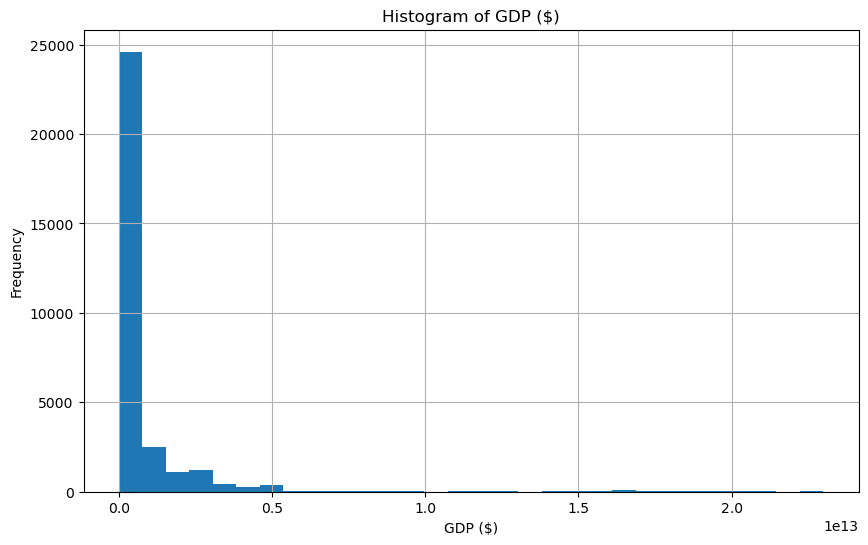

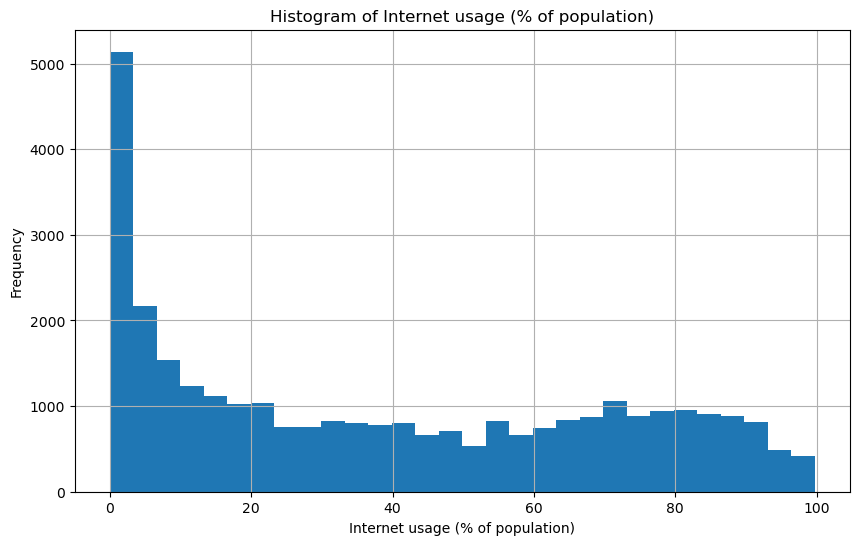

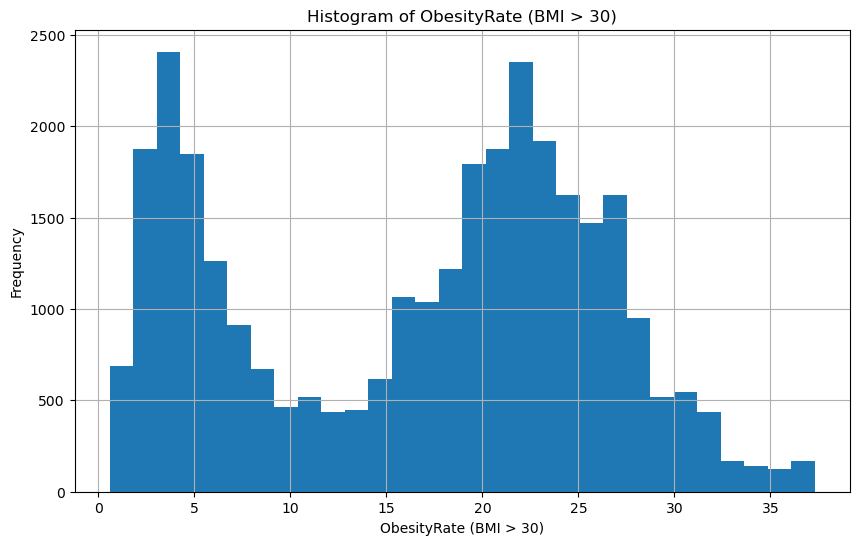

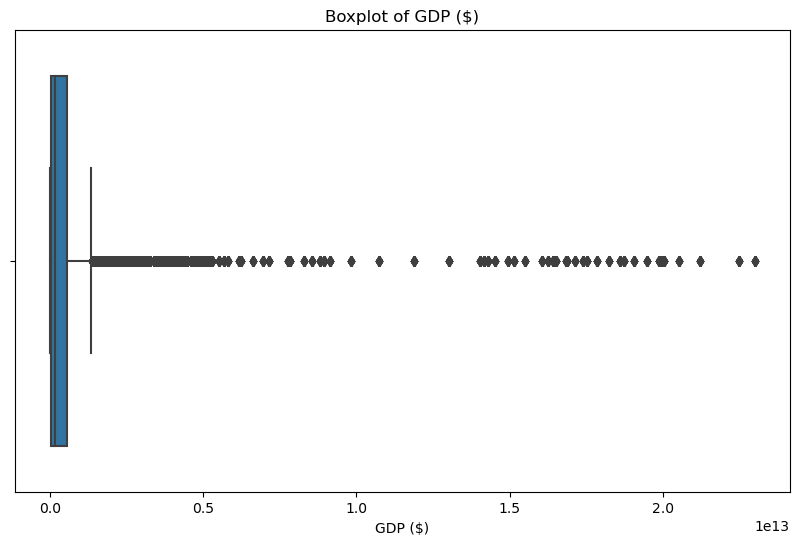

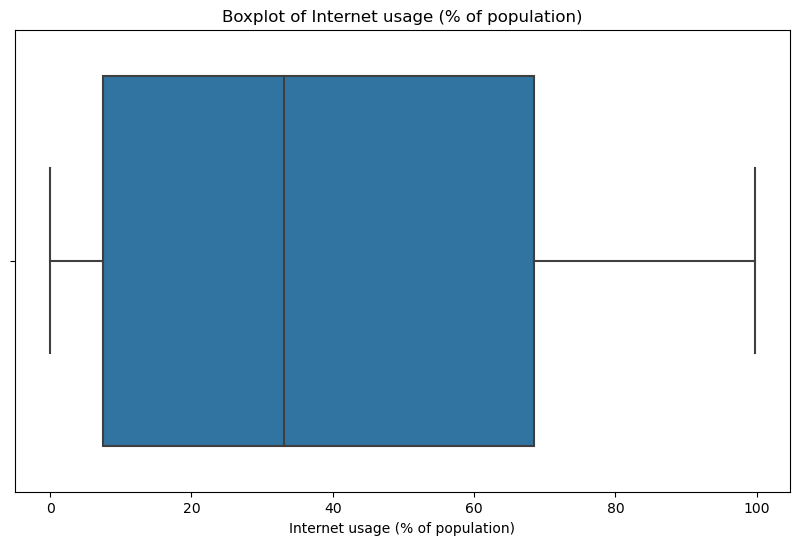

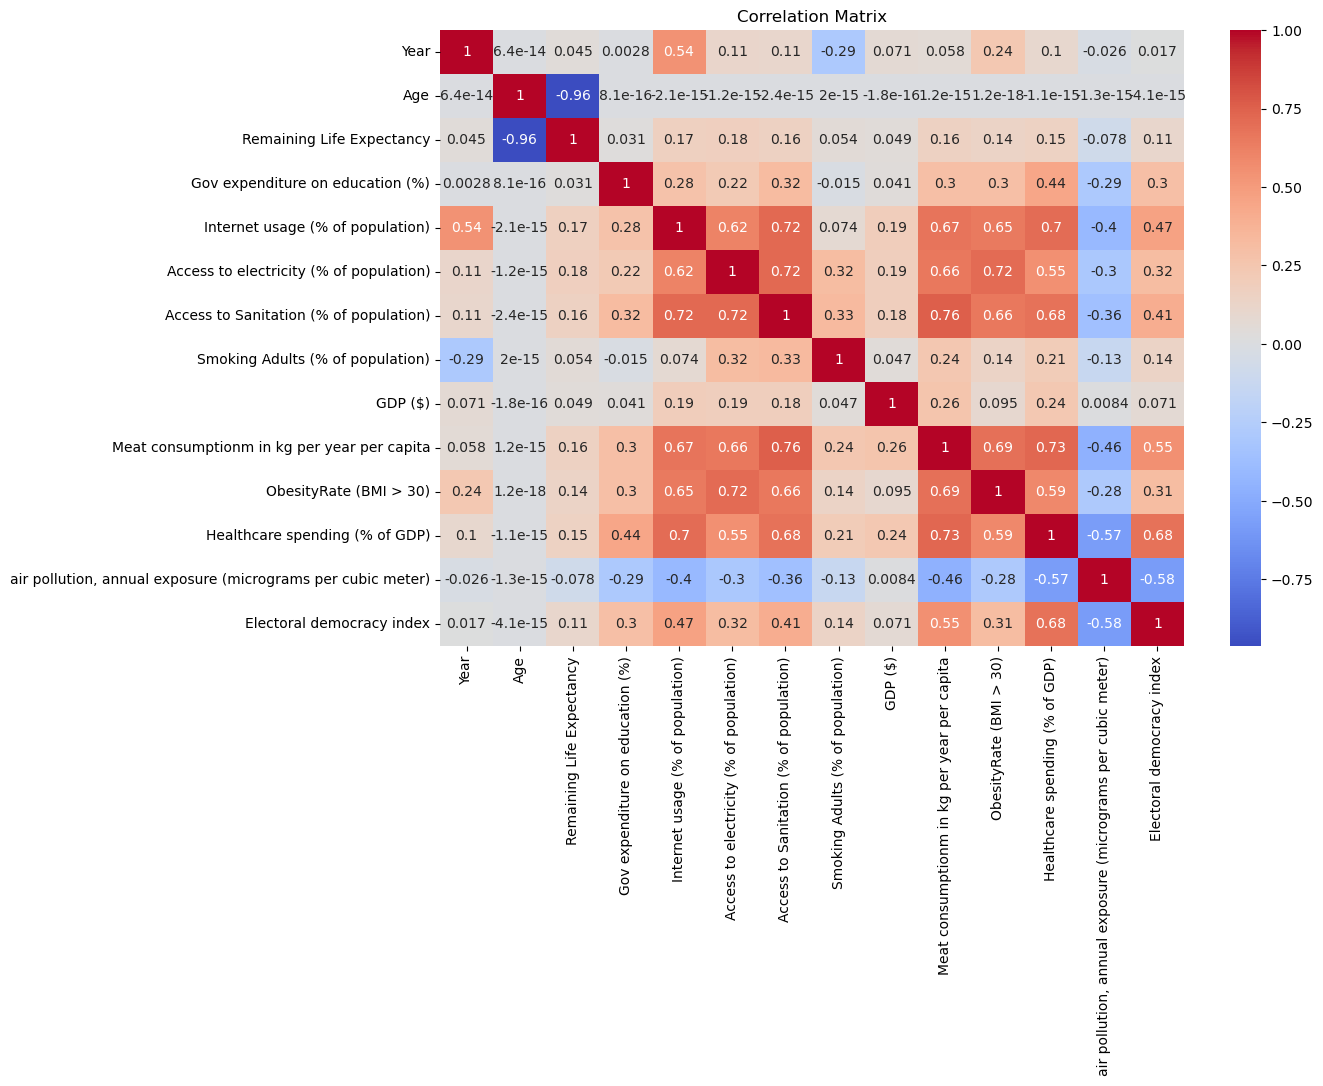

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# Load the final merged dataset
final_df = pd.read_csv('final_merged_data.csv')
 
# Display basic descriptive statistics
print("Descriptive Statistics:")
print(final_df.describe())
 
# Histograms for selected columns
columns_to_visualize = ['GDP ($)', 'Internet usage (% of population)', 'ObesityRate (BMI > 30)']
for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    final_df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
 
# Boxplots for potential outlier detection in specific columns
columns_for_outliers = ['GDP ($)', 'Internet usage (% of population)']
for column in columns_for_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=final_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()
 
# Correlation matrix (optional)
plt.figure(figsize=(12, 8))
# Update here: specify numeric_only=True
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection & Engineering

Korrelationen und welches sind wichtige features
binary encoding for categorial variables

In [55]:
# List of countries to be removed
countries_to_remove = [
    'United Arab Emirates', 'Cayman Islands', 'Suriname', 'Curacao', 'Turkmenistan',
    'South Sudan', 'Uzbekistan', 'Palestine', 'East Timor', 'Liberia', 'Vietnam', 'Nauru',
    'Serbia', 'American Samoa', 'Bahrain', 'Kosovo', 'Curacao', 'South Sudan', 'North Korea',
    'Liberia', 'South Sudan', 'Turks and Caicos Islands', 'Greenland', 'Channel Islands',
    'Montenegro', 'Djibouti', 'Somalia', 'Turks and Caicos Islands', 'Sint Maarten (Dutch part)',
    'Kosovo', 'Cayman Islands', 'Bahrain', 'Bhutan', 'Micronesia (country)', 'Nauru', 'Qatar',
    'South Sudan', 'Burundi', 'Sudan', 'Comoros', 'Democratic Republic of Congo', 'Libya',
    'Papua New Guinea', 'Seychelles', 'Syria', 'Montenegro', 'Serbia', 'South Sudan',
    'Montenegro', 'Zimbabwe'
]

# Remove rows with the specified countries
final_df = final_df[~final_df['Entity'].isin(countries_to_remove)]

final_df


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,United States,USA,2016,Male,80,8.7799,4.806660,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,United States,USA,2017,Male,80,8.7725,5.122880,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,United States,USA,2018,Male,80,8.8969,4.928890,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,United States,USA,2019,Male,80,9.0346,4.987280,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


#### Binary encoding

In [56]:

final_df2 = final_df.drop('Code', axis=1)
 
# Selected columns for binary encoding
columns_to_encode = ['Sex', 'Entity']
 
# Create a new DataFrame for training with binary encoding
encoder = ce.BinaryEncoder(cols=columns_to_encode, drop_invariant=True, return_df=True)

training_dataset = encoder.fit_transform(final_df2)
 
# Save the original column names before encoding
original_columns = encoder.get_feature_names_out()
 
# Save the result

training_dataset.to_csv('training_dataset_binary.csv', index=False)
 
# Back-encode to get the original DataFrame
original_df = encoder.inverse_transform(training_dataset[original_columns])
 
training_dataset

,Entity_0,Entity_1,Entity_2,Entity_3,Entity_4,Entity_5,Entity_6,Year,Sex_0,Sex_1,...,Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,0,0,0,0,0,0,1,2000,0,1,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,0,0,0,0,0,0,1,2001,0,1,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,0,0,0,0,0,0,1,2002,0,1,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,0,0,0,0,0,0,1,2003,0,1,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,0,0,0,0,0,0,1,2004,0,1,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,1,1,0,0,0,1,1,2016,1,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,1,1,0,0,0,1,1,2017,1,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,1,1,0,0,0,1,1,2018,1,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,1,1,0,0,0,1,1,2019,1,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


#### onehot encoding

In [57]:
final_df2 = final_df.drop('Code', axis=1)

# Selected columns for one-hot encoding
columns_to_encode = ['Sex', 'Entity']

# Create a new DataFrame for training with one-hot encoding
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

training_dataset_onehot = encoder.fit_transform(final_df2)

# Save the result as CSV
training_dataset_onehot.to_csv('training_dataset_onehot.csv', index=False)

training_dataset_onehot

,Entity_Algeria,Entity_Argentina,Entity_Armenia,Entity_Australia,Entity_Austria,Entity_Azerbaijan,Entity_Bangladesh,Entity_Belarus,Entity_Belgium,Entity_Benin,...,Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,1,0,0,0,0,0,0,0,0,0,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,1,0,0,0,0,0,0,0,0,0,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,1,0,0,0,0,0,0,0,0,0,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,1,0,0,0,0,0,0,0,0,0,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,1,0,0,0,0,0,0,0,0,0,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,0,0,0,0,0,0,0,0,0,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,0,0,0,0,0,0,0,0,0,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,0,0,0,0,0,0,0,0,0,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,0,0,0,0,0,0,0,0,0,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


### List the encodings

In [58]:
# Extract binary encoded 'Entity' columns
binary_encoded_entities = training_dataset.filter(regex='^Entity_')

# Retrieve the original 'Entity' values from the back-encoded DataFrame
original_entities = original_df['Entity']

# Create a DataFrame that pairs each original 'Entity' with its binary encoding
entity_binary_encoding = pd.concat([original_entities, binary_encoded_entities], axis=1).drop_duplicates()

# Convert the DataFrame to a list of tuples for easier reading
entity_binary_encoding_list = list(entity_binary_encoding.itertuples(index=False, name=None))

# Print the list to see the original 'Entity' and their binary encodings
for item in entity_binary_encoding_list:
    print(item)




('Algeria', 0, 0, 0, 0, 0, 0, 1)
('Argentina', 0, 0, 0, 0, 0, 1, 0)
('Armenia', 0, 0, 0, 0, 0, 1, 1)
('Australia', 0, 0, 0, 0, 1, 0, 0)
('Austria', 0, 0, 0, 0, 1, 0, 1)
('Azerbaijan', 0, 0, 0, 0, 1, 1, 0)
('Bangladesh', 0, 0, 0, 0, 1, 1, 1)
('Belarus', 0, 0, 0, 1, 0, 0, 0)
('Belgium', 0, 0, 0, 1, 0, 0, 1)
('Benin', 0, 0, 0, 1, 0, 1, 0)
('Brazil', 0, 0, 0, 1, 0, 1, 1)
('Bulgaria', 0, 0, 0, 1, 1, 0, 0)
('Burkina Faso', 0, 0, 0, 1, 1, 0, 1)
('Cambodia', 0, 0, 0, 1, 1, 1, 0)
('Canada', 0, 0, 0, 1, 1, 1, 1)
('Chad', 0, 0, 1, 0, 0, 0, 0)
('Chile', 0, 0, 1, 0, 0, 0, 1)
('China', 0, 0, 1, 0, 0, 1, 0)
('Colombia', 0, 0, 1, 0, 0, 1, 1)
('Costa Rica', 0, 0, 1, 0, 1, 0, 0)
("Cote d'Ivoire", 0, 0, 1, 0, 1, 0, 1)
('Croatia', 0, 0, 1, 0, 1, 1, 0)
('Cyprus', 0, 0, 1, 0, 1, 1, 1)
('Czechia', 0, 0, 1, 1, 0, 0, 0)
('Denmark', 0, 0, 1, 1, 0, 0, 1)
('Dominican Republic', 0, 0, 1, 1, 0, 1, 0)
('Ecuador', 0, 0, 1, 1, 0, 1, 1)
('Egypt', 0, 0, 1, 1, 1, 0, 0)
('Estonia', 0, 0, 1, 1, 1, 0, 1)
('Ethiopia', 0, 0, 

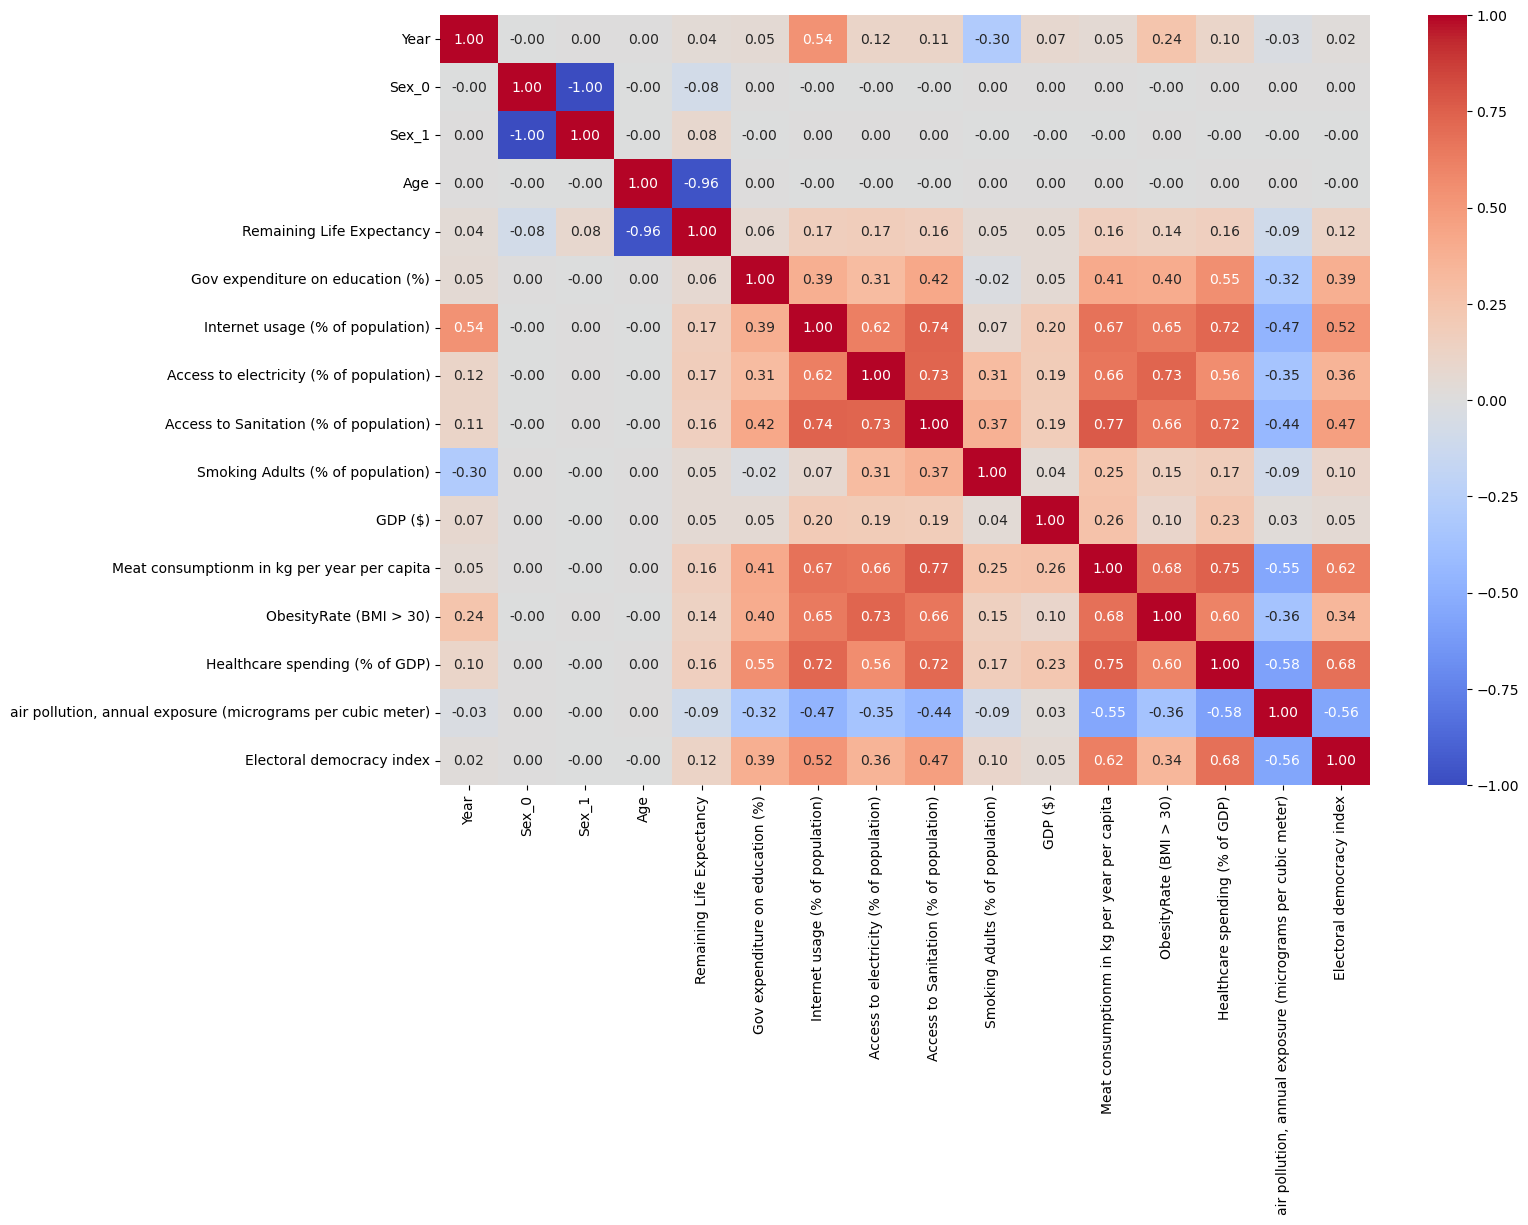

In [59]:
# Exclude columns 'Entity_0' to 'Entity_6' from the correlation matrix
columns_to_exclude = [f'Entity_{i}' for i in range(7)]  # Assuming you have 'Entity_0' to 'Entity_6'
correlation_matrix = training_dataset.drop(columns=columns_to_exclude).corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()
#    0 to 0.2: Very weak correlation
#    0.2 to 0.4: Weak correlation
#    0.4 to 0.6: Moderate correlation
#    0.6 to 0.8: Strong correlation
#    0.8 to 1.0: Very strong correlation

# Anwendung in Machine Learning

#### Linear regression SGD

In [60]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def train_and_evaluate(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Splitting the data
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Creating and training the SGD Regressor
    sgd_reg = SGDRegressor(random_state=42)
    sgd_reg.fit(X_train_scaled, y_train)

    # Predictions and Evaluation
    y_pred = sgd_reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': sgd_reg,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'metrics': {'RMSE': rmse, 'R2': r2},
        'feature_names': X.columns 
    }

# Running the function for both datasets
results_binary = train_and_evaluate('training_dataset_binary.csv')
results_onehot = train_and_evaluate('training_dataset_onehot.csv')


# Printing results and saving metrics
metrics = {
    'binary': results_binary['metrics'],
    'onehot': results_onehot['metrics']
}

print(f"Metrics for Binary Encoded Data: {metrics['binary']}")
print(f"Metrics for One-Hot Encoded Data: {metrics['onehot']}")

Metrics for Binary Encoded Data: {'RMSE': 3.7816978241830657, 'R2': 0.974495854804723}
Metrics for One-Hot Encoded Data: {'RMSE': 3.2676450728971567, 'R2': 0.98095824904745}


#### XGBoost

In [61]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate_xgb(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'metrics': {'RMSE': rmse, 'R2': r2}
    }

# Running the function for both datasets
xgb_metrics_binary = train_and_evaluate_xgb('training_dataset_binary.csv')
xgb_metrics_onehot = train_and_evaluate_xgb('training_dataset_onehot.csv')

# Printing only the metrics
print("XGBoost Metrics:")
print(f"Binary Encoded Data: RMSE = {xgb_metrics_binary['metrics']['RMSE']}, R2 = {xgb_metrics_binary['metrics']['R2']}")
print(f"One-Hot Encoded Data: RMSE = {xgb_metrics_onehot['metrics']['RMSE']}, R2 = {xgb_metrics_onehot['metrics']['R2']}")

# Adding XGBoost metrics to the metrics dictionary
metrics['xgboost_binary'] = xgb_metrics_binary
metrics['xgboost_onehot'] = xgb_metrics_onehot


XGBoost Metrics:
Binary Encoded Data: RMSE = 0.6732615972719469, R2 = 0.9991916400078902
One-Hot Encoded Data: RMSE = 0.6703531866809824, R2 = 0.9991986089621817


#### Random Forest

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def train_and_evaluate_rf(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
   
    return {
        'model': rf_model,
        'X': X,
        'y': y,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'metrics': {'RMSE': rmse, 'R2': r2}
    }

# Running the function for both datasets
rf_metrics_binary = train_and_evaluate_rf('training_dataset_binary.csv')
rf_metrics_onehot = train_and_evaluate_rf('training_dataset_onehot.csv')

# Printing only the metrics
print("Random Forest Metrics:")
print(f"Binary Encoded Data: RMSE = {rf_metrics_binary['metrics']['RMSE']}, R2 = {rf_metrics_binary['metrics']['R2']}")
print(f"One-Hot Encoded Data: RMSE = {rf_metrics_onehot['metrics']['RMSE']}, R2 = {rf_metrics_onehot['metrics']['R2']}")

# Adding Random Forest metrics to the metrics dictionary
metrics['rf_binary'] = rf_metrics_binary['metrics']
metrics['rf_onehot'] = rf_metrics_onehot['metrics']


Random Forest Metrics:
Binary Encoded Data: RMSE = 0.6687998531559722, R2 = 0.9992023186046252
One-Hot Encoded Data: RMSE = 0.63848720676795, R2 = 0.9992729880919071


In [67]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(X_train, y_train, title_suffix):
    param_range = [10, 20, 30, 40, 50, 100]
    train_scores, test_scores = validation_curve(
        RandomForestRegressor(random_state=42), X_train, y_train, param_name='n_estimators', param_range=param_range,
        cv=5, scoring='neg_mean_squared_error'
    )

    # Convert from negative MSE to RMSE
    train_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_mean = np.sqrt(-np.mean(test_scores, axis=1))

    # Plotting the validation curve
    plt.plot(param_range, train_mean, label='Training Error')
    plt.plot(param_range, test_mean, label='Test Error')
    plt.xlabel('Number of Trees')
    plt.ylabel('RMSE')
    plt.title(f'Random Forest Regressor Validation Curve - {title_suffix}')
    plt.legend()
    plt.show()


# Plotting validation curves for both datasets
plot_validation_curve(rf_results_binary['X_train'], rf_results_binary['y_train'], 'Binary Encoded Data')
plot_validation_curve(rf_results_onehot['X_train'], rf_results_onehot['y_train'], 'One-Hot Encoded Data')

NameError: name 'rf_results_binary' is not defined

In [ ]:
from sklearn.model_selection import learning_curve
 
def plot_learning_curve(model, X, y, title_suffix):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error'
    )

    # Convert from negative MSE to RMSE
    train_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_mean = np.sqrt(-np.mean(test_scores, axis=1))

    # Plotting the learning curve
    plt.plot(train_sizes, train_mean, label='Training Error')
    plt.plot(train_sizes, test_mean, label='Test Error')
    plt.xlabel('Training Data Size')
    plt.ylabel('RMSE')
    plt.title(f'Random Forest Regressor Learning Curve - {title_suffix}')
    plt.legend()
    plt.show()

# Plotting learning curves for both datasets
plot_learning_curve(rf_results_binary['model'], rf_results_binary['X'], rf_results_binary['y'], 'Binary Encoded Data')
plot_learning_curve(rf_results_onehot['model'], rf_results_onehot['X'], rf_results_onehot['y'], 'One-Hot Encoded Data')

#### Feedforward Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

def train_and_evaluate_nn(dataset_filename, save_model=False):
    # Load the dataset
    data = pd.read_csv(dataset_filename)  

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1).values
    y = data['Remaining Life Expectancy'].values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    # Create PyTorch datasets and DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # Model, Loss, and Optimizer
    model = NeuralNet(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    patience = 20
    best_loss = float('inf')
    epochs_no_improve = 0

    # Training the Model
    num_epochs = 200
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

        # Check for early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs!')
            break

    # Evaluate the model on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    y_test_pred = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
            y_test_pred.extend(outputs.numpy().squeeze())

    avg_test_loss = test_loss / len(test_loader)
    rmse = np.sqrt(avg_test_loss)
    r2 = r2_score(y_test, y_test_pred)

    # Save the model and scaler if required
    if save_model:
        joblib.dump(scaler, 'frontend/scaler.save')
        torch.save(model.state_dict(), 'frontend/FNN_model.pth')

    # Return the losses along with metrics
    return {'RMSE': rmse, 'R2': r2, 'train_losses': train_losses, 'val_losses': val_losses}

# Running the function for both datasets
nn_metrics_binary = train_and_evaluate_nn('training_dataset_binary.csv', save_model=True)
nn_metrics_onehot = train_and_evaluate_nn('training_dataset_onehot.csv')

# Printing results
print("Neural Network Metrics:")
print(f"Binary Encoded Data: RMSE = {nn_metrics_binary['RMSE']}, R2 = {nn_metrics_binary['R2']}")
print(f"One-Hot Encoded Data: RMSE = {nn_metrics_onehot['RMSE']}, R2 = {nn_metrics_onehot['R2']}")

# Adding Neural Network metrics to the existing metrics dictionary
metrics['nn_binary'] = nn_metrics_binary
metrics['nn_onehot'] = nn_metrics_onehot

# Printing results
print("Neural Network Metrics:")
print(f"Binary Encoded Data: RMSE = {nn_metrics_binary['RMSE']}, R2 = {nn_metrics_binary['R2']}")
print(f"One-Hot Encoded Data: RMSE = {nn_metrics_onehot['RMSE']}, R2 = {nn_metrics_onehot['R2']}")


Epoch [1/200], Validation Loss: 12.1415
Epoch [2/200], Validation Loss: 5.2597
Epoch [3/200], Validation Loss: 3.3735
Epoch [4/200], Validation Loss: 2.6181
Epoch [5/200], Validation Loss: 2.0885
Epoch [6/200], Validation Loss: 1.7358
Epoch [7/200], Validation Loss: 1.4270
Epoch [8/200], Validation Loss: 1.2207
Epoch [9/200], Validation Loss: 1.1486
Epoch [10/200], Validation Loss: 0.9692
Epoch [11/200], Validation Loss: 1.0052
Epoch [12/200], Validation Loss: 0.8481
Epoch [13/200], Validation Loss: 0.8344
Epoch [14/200], Validation Loss: 0.7461
Epoch [15/200], Validation Loss: 0.8868
Epoch [16/200], Validation Loss: 0.6935
Epoch [17/200], Validation Loss: 0.7261
Epoch [18/200], Validation Loss: 0.8180
Epoch [19/200], Validation Loss: 0.6401
Epoch [20/200], Validation Loss: 0.6284
Epoch [21/200], Validation Loss: 0.5347
Epoch [22/200], Validation Loss: 0.5049
Epoch [23/200], Validation Loss: 0.4671
Epoch [24/200], Validation Loss: 0.5474
Epoch [25/200], Validation Loss: 0.5367
Epoch [2

In [68]:
# Plotting the training and validation losses
plt.plot(range(4, len(nn_metrics_binary['train_losses'])), nn_metrics_binary['train_losses'][4:], label='Training Loss')
plt.plot(range(4, len(nn_metrics_binary['val_losses'])), nn_metrics_binary['val_losses'][4:], label='Validation Loss')
plt.title('Training and Validation Losses for Binary Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation losses
plt.plot(range(4, len(nn_metrics_onehot['train_losses'])), nn_metrics_onehot['train_losses'][4:], label='Training Loss')
plt.plot(range(4, len(nn_metrics_onehot['val_losses'])), nn_metrics_onehot['val_losses'][4:], label='Validation Loss')
plt.title('Training and Validation Losses for Binary Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyError: 'train_losses'

#### Cross Validation

In [ ]:
array = df.values
X = array[:,1:30]
Y = array[:,0]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=1000, solver='liblinear')))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(max_depth=9)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=15)))
models.append(('RF', RandomForestClassifier(max_depth = 3, max_leaf_nodes = 3, n_estimators = 3, random_state = 42)))
models.append(('SVM', svm.SVC()))
models.append(('NN', MLPClassifier(hidden_layer_sizes = 17, activation = 'relu', random_state = 42)))
models.append(('XGB', XGBClassifier(random_state=42,gpu_id=0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: name 'LogisticRegression' is not defined

# Anwendung von XAI – Techniken

##### SDG Regression

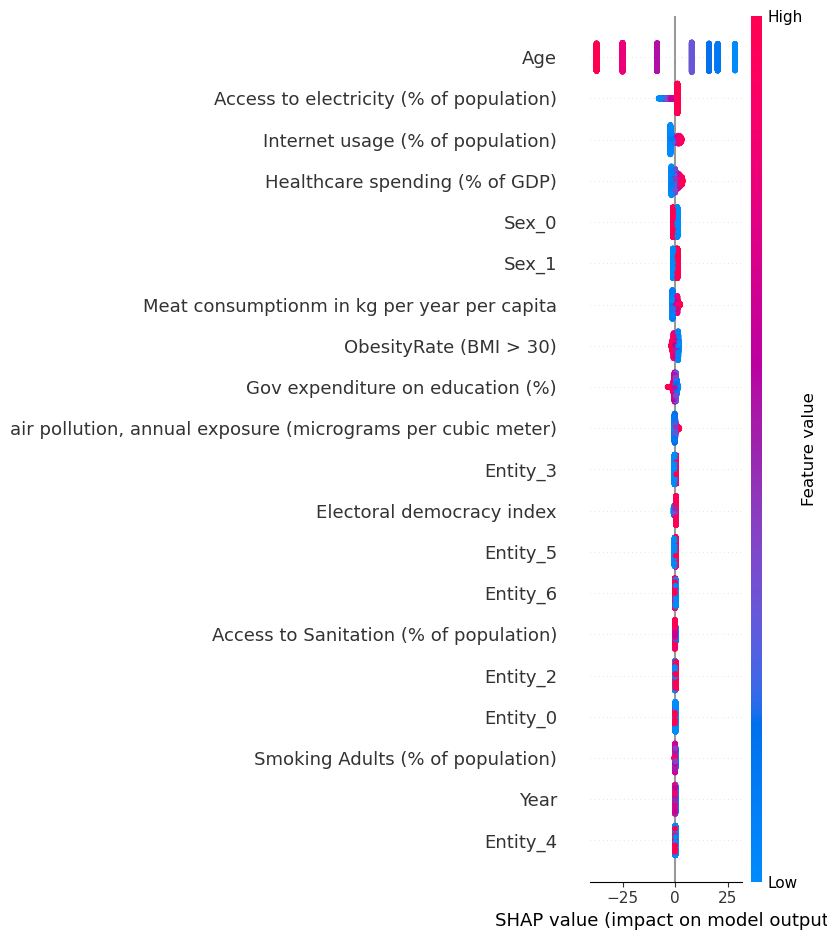

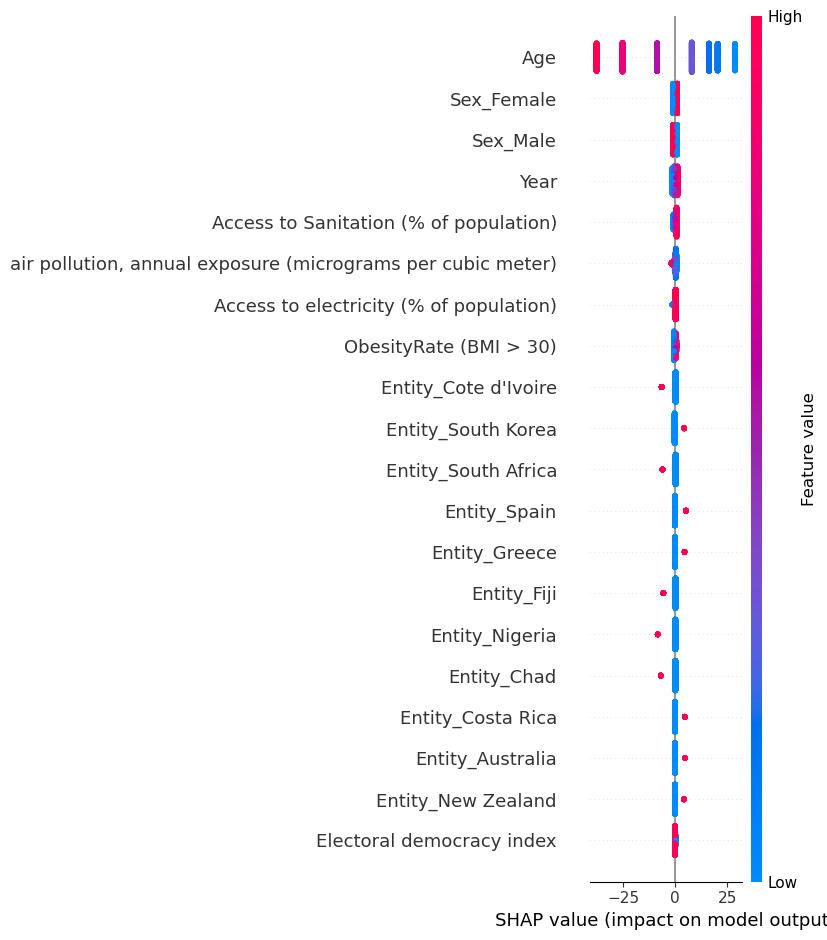

In [ ]:
# Creating SHAP explainers
explainer_binary_reg = shap.Explainer(results_binary['model'], results_binary['X_train_scaled'])
shap_values_binary_reg = explainer_binary_reg(results_binary['X_test_scaled'])

explainer_onehot_reg = shap.Explainer(results_onehot['model'], results_onehot['X_train_scaled'])
shap_values_onehot_reg = explainer_onehot_reg(results_onehot['X_test_scaled'])


# Visualizing SHAP values
shap.summary_plot(shap_values_binary_reg, results_binary['X_test_scaled'], feature_names=results_binary['feature_names'])
shap.summary_plot(shap_values_onehot_reg, results_onehot['X_test_scaled'], feature_names=results_onehot['feature_names'])

##### XGBoost

[12:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[12:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[12:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


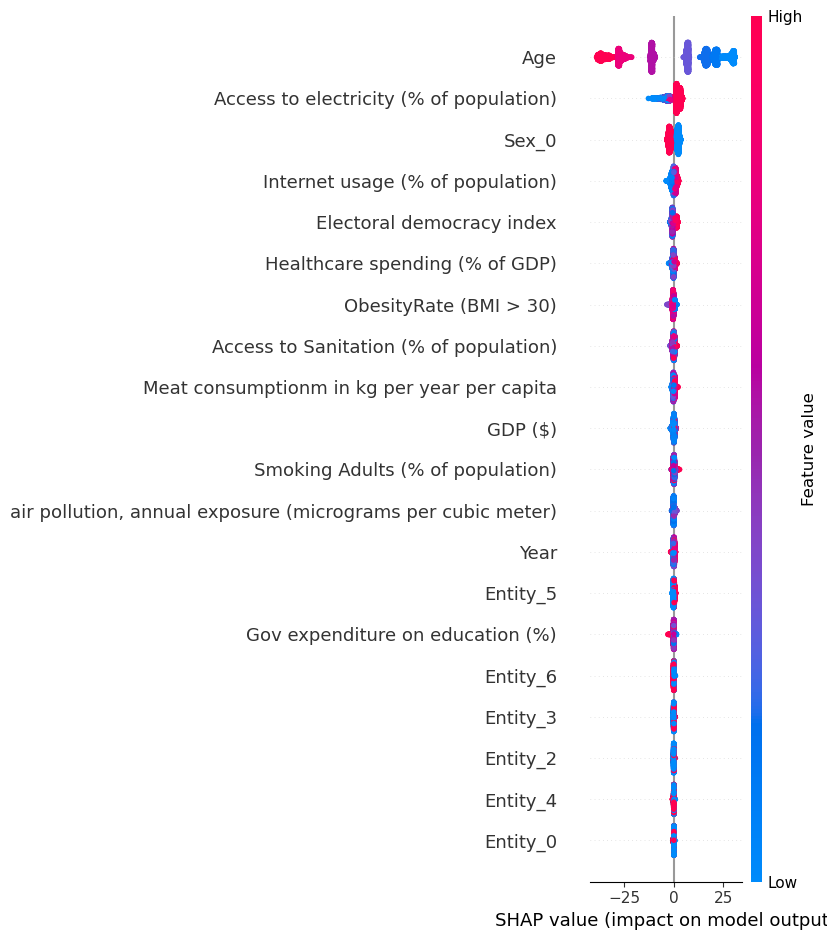

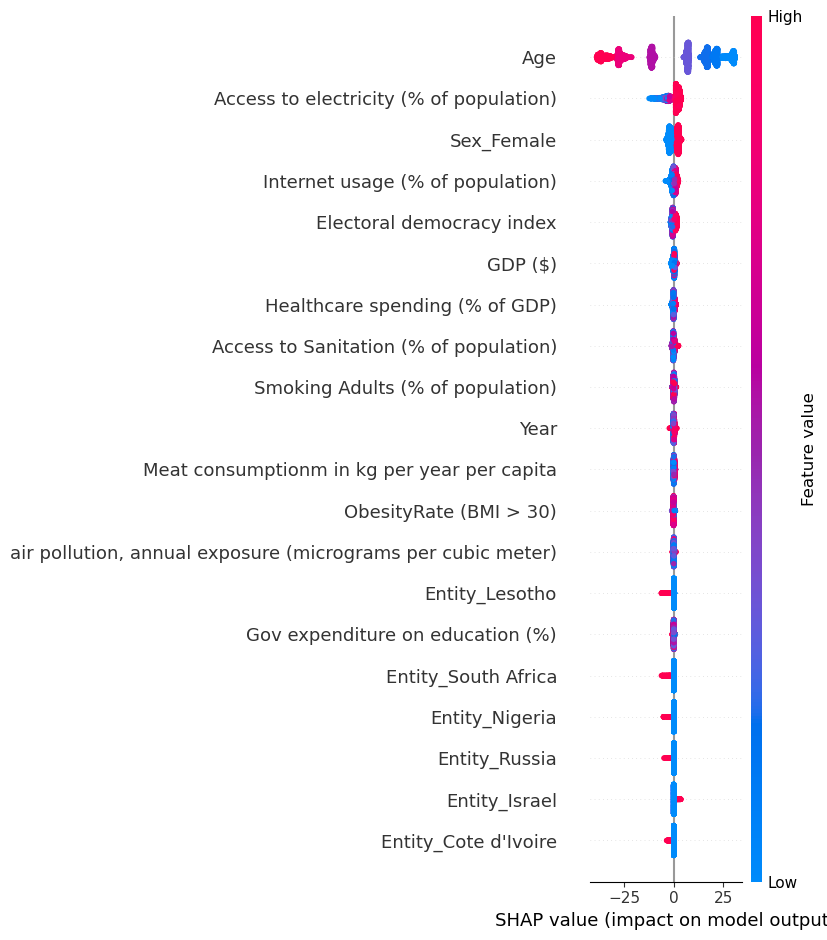

In [ ]:
# Running the function for both datasets
results_xgb_binary = train_and_evaluate_xgb('training_dataset_binary.csv')
results_xgb_onehot = train_and_evaluate_xgb('training_dataset_onehot.csv')

# Creating SHAP explainers for XGBoost models
explainer_xgb_binary = shap.Explainer(results_xgb_binary['model'])
shap_values_xgb_binary = explainer_xgb_binary(results_xgb_binary['X_test'])

explainer_xgb_onehot = shap.Explainer(results_xgb_onehot['model'])
shap_values_xgb_onehot = explainer_xgb_onehot(results_xgb_onehot['X_test'])

# Visualizing SHAP values
shap.summary_plot(shap_values_xgb_binary, results_xgb_binary['X_test'])
shap.summary_plot(shap_values_xgb_onehot, results_xgb_onehot['X_test'])


##### Random Forest

##### FNN